# Neuroblastoma

## Imports python

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torchmetrics.classification as classification
import copy
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from tqdm import tqdm

UP_LINE  = "\033[A"
DEL_LINE = "\033[K"

/home/pierre/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Vérification GPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Chargement des datasets et preprocessing

In [3]:
# root_dir  = "../database/224x224_split_BA"
root_dir  = "../database/db_mat_224_FA"
train_dir = "train/"
# valid_dir = "validation/"
valid_dir = "test/"
test_dir  = "test/"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.644193498371542, 0.5645996565889991, 0.7588836765196458), (0.21690568815789038, 0.2163005157370828, 0.13590056909053988))
    transforms.Normalize((0.6675633854729178, 0.5748515449722628, 0.7695707113605876), (0.21134008037102184, 0.2146980755715314, 0.1345160446951044))
])

# Chargement des données
train_dataset = datasets.ImageFolder(f"{root_dir}/{train_dir}", transform)
valid_dataset = datasets.ImageFolder(f"{root_dir}/{valid_dir}", transform)
test_dataset  = datasets.ImageFolder(f"{root_dir}/{test_dir}",  transform)

## Modèle

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3)),
            nn.LeakyReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten()
        )
        self.nn = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        a = self.cnn(x)
        b = self.nn(a)
        return b

## Entraînement

In [8]:
batch_size = 32
lr = 1e-5
epochs = 20

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr, betas=(0.9, 0.999))
criterion = nn.BCELoss()
accuracy = classification.BinaryAccuracy().to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size, shuffle=False)

In [9]:
def train_model(model, loader, criterion, accuracy, epoch:int=0):
    loss = 0.0
    accuracy.reset()
    with tqdm(loader, unit="batch", leave=False) as train_epoch:
        train_epoch.set_description(f"Epoch {epoch:2d} (train)")
        model.train()
        for (inputs, labels) in train_epoch:
            (inputs, labels) = (inputs.to(device), labels.to(device))
            labels  = labels.unsqueeze(1).to(torch.float32)
            outputs = model(inputs)
            cr_loss = criterion(outputs, labels)

            optimizer.zero_grad()
            cr_loss.backward()
            optimizer.step()

            loss+=cr_loss.item()
            accuracy(outputs, labels)

    loss = loss / len(loader)
    accu = accuracy.compute().item()
    return loss, accu


def eval_model(model, loader, criterion, accuracy, epoch:int=0):
    loss = 0.0
    accuracy.reset()
    with torch.no_grad():    
        with tqdm(valid_loader, unit="batch", leave=False) as eval_epoch:
            eval_epoch.set_description(f"Epoch {epoch:2d} (eval)")
            model.eval()
            for (inputs, labels) in eval_epoch:
                (inputs, labels) = (inputs.to(device), labels.to(device))
                labels  = labels.unsqueeze(1).to(torch.float32)
                outputs = model(inputs)
                cr_loss = criterion(outputs, labels)

                loss+=cr_loss.item()
                accuracy(outputs, labels)
    loss = loss / len(loader)
    accu = accuracy.compute().item()
    return loss, accu

# Historic
H = {
    "train_loss": np.zeros((epochs+1), dtype=np.float32),
    "train_accu": np.zeros((epochs+1), dtype=np.float32),
    "valid_loss": np.zeros((epochs+1), dtype=np.float32),
    "valid_accu": np.zeros((epochs+1), dtype=np.float32)
}
H["train_loss"][0] = None
H["train_accu"][0] = None

(valid_loss, valid_accu) =  eval_model(model, valid_loader, criterion, accuracy, epoch=0)
H["valid_loss"][0] = valid_loss
H["valid_accu"][0] = valid_accu
best_valid_accu = valid_accu
best_model = copy.deepcopy(model)
print(f"{UP_LINE}{DEL_LINE}Epoch  0: Valid Loss={H['valid_loss'][0]:.3f} | Valid Acc={H['valid_accu'][0]:.2f}")

for e in range(1, epochs+1):
    (train_loss, train_accu) = train_model(model, train_loader, criterion, accuracy, e)
    (valid_loss, valid_accu) =  eval_model(model, valid_loader, criterion, accuracy, e)

    if valid_accu > best_valid_accu:
        best_valid_accu = valid_accu
        best_model = copy.deepcopy(model)
    
    H["train_loss"][e] = train_loss
    H["train_accu"][e] = train_accu
    H["valid_loss"][e] = valid_loss
    H["valid_accu"][e] = valid_accu

    print(f"Epoch {e:2d}: Valid Loss={H['valid_loss'][e]:.3f} | Valid Acc={H['valid_accu'][e]:.2f} | Train Loss={H['train_loss'][e]:.3f} | Train Acc={H['train_accu'][e]:.2f}")

(test_loss, test_accu) = eval_model(best_model, test_loader, criterion, accuracy)
print(f"Best model: Loss={test_loss:.3f} | Acc={test_accu:.3f}")

Epoch  0: Valid Loss=0.692 | Valid Acc=0.64


Epoch  1: Valid Loss=0.840 | Valid Acc=0.54 | Train Loss=0.568 | Train Acc=0.76


Epoch  2: Valid Loss=0.718 | Valid Acc=0.65 | Train Loss=0.349 | Train Acc=0.86


Epoch  3: Valid Loss=0.636 | Valid Acc=0.64 | Train Loss=0.265 | Train Acc=0.87


Epoch  4: Valid Loss=0.609 | Valid Acc=0.65 | Train Loss=0.224 | Train Acc=0.89


Epoch  5: Valid Loss=0.509 | Valid Acc=0.69 | Train Loss=0.200 | Train Acc=0.90


Epoch  6: Valid Loss=0.492 | Valid Acc=0.70 | Train Loss=0.176 | Train Acc=0.91


Epoch  7: Valid Loss=0.444 | Valid Acc=0.72 | Train Loss=0.158 | Train Acc=0.93


Epoch  8: Valid Loss=0.536 | Valid Acc=0.70 | Train Loss=0.142 | Train Acc=0.94


Epoch  9: Valid Loss=0.362 | Valid Acc=0.79 | Train Loss=0.123 | Train Acc=0.95


Epoch 10: Valid Loss=0.338 | Valid Acc=0.80 | Train Loss=0.113 | Train Acc=0.96


Epoch 11: Valid Loss=0.420 | Valid Acc=0.77 | Train Loss=0.102 | Train Acc=0.97


Epoch 12: Valid Loss=0.358 | Valid Acc=0.79 | Train Loss=0.092 | Train Acc=0.97


Epoch 13: Valid Loss=0.298 | Valid Acc=0.84 | Train Loss=0.085 | Train Acc=0.98


Epoch 14: Valid Loss=0.310 | Valid Acc=0.83 | Train Loss=0.079 | Train Acc=0.98


Epoch 15: Valid Loss=0.306 | Valid Acc=0.83 | Train Loss=0.073 | Train Acc=0.98


Epoch 16: Valid Loss=0.379 | Valid Acc=0.80 | Train Loss=0.066 | Train Acc=0.98


Epoch 17: Valid Loss=0.265 | Valid Acc=0.86 | Train Loss=0.065 | Train Acc=0.98


Epoch 18: Valid Loss=0.435 | Valid Acc=0.78 | Train Loss=0.059 | Train Acc=0.98


Epoch 19: Valid Loss=0.278 | Valid Acc=0.86 | Train Loss=0.054 | Train Acc=0.99


Epoch 20: Valid Loss=0.181 | Valid Acc=0.92 | Train Loss=0.054 | Train Acc=0.98


Best model: Loss=0.181 | Acc=0.918


## Visualisation des courbes d'apprentissage

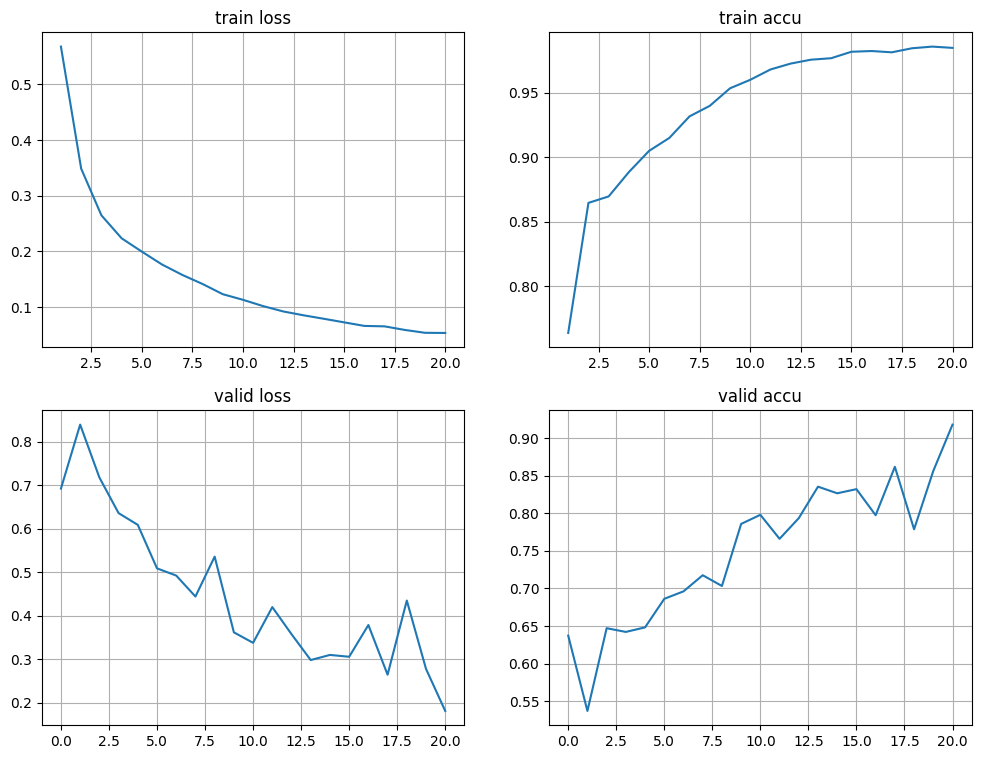

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
axs = axs.flatten()

for ax, (key, metric) in zip(axs, H.items()):
    ax.plot(np.arange(len(metric)), metric)
    ax.set_title(key.replace("_", " "))
    ax.grid()
    
import json
plt.savefig("fig/db_mat_FA_1.svg")
for key, tab in H.items():
    H[key] = tab.tolist()

with open("fig/db_mat_FA_1.json", "w") as fp:
    json.dump(H, fp)